In [ ]:
!pip install fluidsynth

  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4513 sha256=c740c88e75b3963f844a8c50e86285f09f7f9c398cd5de1deaead8ae8c3aaf06
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built fluidsynth


In [ ]:
!apt install fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [ ]:
path = './drive/MyDrive/Midi_Project/'

In [ ]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes = np.load(path+file, allow_pickle=True)

    for i in range(len(notes)):
      notes[i]= np.array(notes[i])

    return np.array(notes)

In [ ]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#reading each midi file
notes_array = read_midi("data/train_bpe.npy")

Loading Music File: data/train_bpe.npy


In [ ]:
!pip install tokenizers

     |████████████████████████████████| 6.8 MB 5.3 MB/s 


In [ ]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file(path + "data/vocab_bpe.json")

In [ ]:
unique_notes = tokenizer.get_vocab_size()
#unique_notes=300

In [ ]:
unique_notes

300

In [ ]:
len(notes_array)

45848

In [ ]:
time_steps = 64
x = []
y = []

for notes in notes_array[:1000]:
  for i in range(0, len(notes)-2*time_steps-1):
    input = notes[i:i+time_steps]
    output = notes[i+time_steps:i+2*time_steps+1]
    x.append(input)
    y.append(output)

x = np.array(x)
y = np.array(y)

In [ ]:
len(x)

240535

In [ ]:
from sklearn.model_selection import train_test_split as tts
x_train, x_val, y_train, y_val = tts(x, y, test_size = 0.10, random_state=0)

In [ ]:
x_vocab = unique_notes
y_vocab = unique_notes

BUFFER_SIZE = len(x_train)
BATCH_SIZE = 256
steps_per_epoch = len(x_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

In [ ]:
x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_val_tensor = tf.convert_to_tensor(x_val)
y_val_tensor = tf.convert_to_tensor(y_val)

dataset = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_data = tf.data.Dataset.from_tensor_slices((x_val_tensor, y_val_tensor)).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 64]), TensorShape([256, 65]))

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(pos, d_model):
  angles_rad = get_angles(np.arange(pos)[:,np.newaxis],np.arange(d_model)[np.newaxis, :], d_model)

  angles_rad[:,0::2] = np.sin(angles_rad[:,0::2])

  angles_rad[:,1::2] = np.cos(angles_rad[:,1::2])

  pos_encoding = angles_rad[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


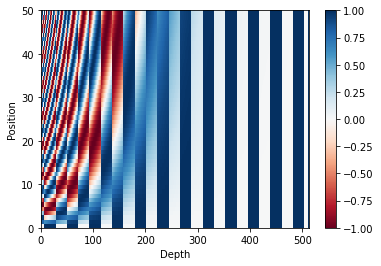

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def create_padding_mask(seq):
  seq=tf.cast(tf.math.equal(seq,0), tf.float32)

  return seq[:,tf.newaxis, tf.newaxis,:]

In [ ]:
def lookahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [ ]:
def scaled_dot_product_attention(q, k, v, Srel, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True) + Srel  

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 

  output = tf.matmul(attention_weights, v)  

  return output, attention_weights


In [ ]:
class MultiheadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, max_seq):
    super(MultiheadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    self.max_seq = max_seq
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
  
  def build(self, input):
    self.E = self.add_weight('emb', shape=[self.max_seq, int(self.depth)])
        
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  
    k = self.wk(k)  
    v = self.wv(v)  

    q = self.split_heads(q, batch_size)  
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  

    self.len_k = k.shape[2]
    self.len_q = q.shape[2]

    #print(self.len_q)

    E = self._get_left_embedding(self.len_q, self.len_k)
    QE = tf.einsum('bhld,md->bhlm', q, E)
    QE = self._qe_masking(QE)
    Srel = self._skewing(QE)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, Srel, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  

    output = self.dense(concat_attention) 
        
    return output, attention_weights
  
  # The following part for Relative Attention is taken from https://github.com/jason9693/MusicTransformer-tensorflow2.0/blob/master/custom/layers.py 
  def _get_left_embedding(self, len_q, len_k):
    starting_point = max(0,self.max_seq-len_q)
    e = self.E[starting_point:,:]
    return e
  
  @staticmethod
  def _qe_masking(qe):
      mask = tf.sequence_mask(tf.range(qe.shape[-1] -1, qe.shape[-1] - qe.shape[-2] -1, -1), qe.shape[-1])
      mask = tf.logical_not(mask)
      mask = tf.cast(mask, tf.float32)

      return mask * qe

  def _skewing(self, tensor: tf.Tensor):
      padded = tf.pad(tensor, [[0, 0], [0,0], [0, 0], [1, 0]])
      reshaped = tf.reshape(padded, shape=[-1, padded.shape[1], padded.shape[-1], padded.shape[-2]])
      Srel = reshaped[:, :, 1:, :]
      # print('Sre: {}'.format(Srel))

      if self.len_k > self.len_q:
          Srel = tf.pad(Srel, [[0,0], [0,0], [0,0], [0, self.len_k-self.len_q]])
      elif self.len_k < self.len_q:
          Srel = Srel[:,:,:,:self.len_k]

      return Srel

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff,max_seq_len, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiheadAttention(d_model, num_heads, max_seq_len)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  
    
    ffn_output = self.ffn(out1)  
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output) 
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, max_seq_len, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiheadAttention(d_model, num_heads, max_seq_len)
    self.mha2 = MultiheadAttention(d_model, num_heads, max_seq_len)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) 
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  
    
    ffn_output = self.ffn(out2)  
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding,max_seq_len, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, max_seq_len, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    return x 

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=unique_notes,
                         maximum_position_encoding=512, max_seq_len=time_steps)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding,max_seq_len, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff,max_seq_len, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x) 
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target,max_seq_len, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input,max_seq_len, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target,max_seq_len, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output) 
    
    return final_output, attention_weights

In [ ]:
num_layers = 2
d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.2
px_vocab = time_steps
py_vocab = time_steps
max_seq_len = time_steps

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.3)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.99, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='validation_loss')

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          x_vocab, y_vocab, 
                          pe_input=px_vocab, 
                          pe_target=py_vocab,
                          max_seq_len = max_seq_len,
                          rate=dropout_rate)

Text(0.5, 0, 'Train Step')

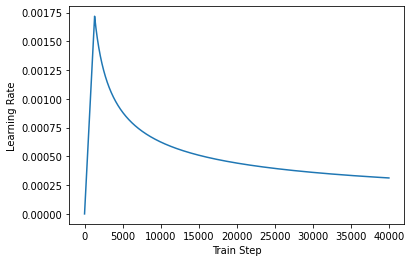

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
pwd()

'/content'

In [ ]:
checkpoint_dir = path+'/models/training_checkpoints_bpe'
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 transformer = transformer)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)


In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, time_steps), dtype=tf.int64),
    tf.TensorSpec(shape=(BATCH_SIZE, time_steps+1), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, targ):
  loss = 0
  tar_inp = targ[:,:-1]
  tar_real = targ[:,1:]

  look_ahead_mask = lookahead_mask(tf.shape(tar_inp)[1])
  enc_padding_mask = None
  dec_padding_mask = None
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 look_ahead_mask, 
                                 dec_padding_mask)
    loss = loss_object(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)

In [ ]:
val_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, time_steps), dtype=tf.int64),
    tf.TensorSpec(shape=(BATCH_SIZE, time_steps+1), dtype=tf.int64),
]
@tf.function(input_signature=val_step_signature)
def validation_step(inp, targ):
  loss = 0
  tar_inp = targ[:,:-1]
  tar_real = targ[:,1:]

  look_ahead_mask = lookahead_mask(tf.shape(tar_inp)[1])
  enc_padding_mask = None
  dec_padding_mask = None
  
  prob, _ = transformer(inp, tar_inp, 
                              False, 
                              enc_padding_mask, 
                              look_ahead_mask, 
                              dec_padding_mask)
  loss = loss_object(tar_real, prob)
  val_loss(loss)

In [ ]:
validation_step(example_input_batch, example_target_batch)

In [ ]:
val_loss.result()

<tf.Tensor: shape=(), dtype=float32, numpy=6.1410966>

In [ ]:
EPOCHS = 10
Best_loss = 1000000

for epoch in range(EPOCHS):
  train_loss.reset_states()
  val_loss.reset_states()

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    train_step(inp, targ)

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   train_loss.result()))
  
  for (inp, targ) in validation_data:
    validation_step(inp, targ)
  
  
  print('Epoch: {}, Train_Loss: {:.4f},  Validation_loss: {:.4f}'.format(epoch + 1,
                                      train_loss.result(), val_loss.result()))
  
  
  if val_loss.result()<Best_loss or (epoch+1)%4==0:
    Best_loss = val_loss.result()
    print("Saving Model Checkpoint....................")
    ckpt_manager.save()

Epoch 1 Batch 0 Loss 6.1458
Epoch 1 Batch 100 Loss 5.1417
Epoch 1 Batch 200 Loss 4.3458
Epoch 1 Batch 300 Loss 3.6082
Epoch 1 Batch 400 Loss 3.0864
Epoch 1 Batch 500 Loss 2.7327
Epoch 1 Batch 600 Loss 2.4755
Epoch 1 Batch 700 Loss 2.2772
Epoch 1 Batch 800 Loss 2.1175
Epoch: 1, Train_Loss: 2.0558,  Validation_loss: 0.7557
Saving Model Checkpoint....................
Epoch 2 Batch 0 Loss 0.9191
Epoch 2 Batch 100 Loss 0.8748
Epoch 2 Batch 200 Loss 0.8380
Epoch 2 Batch 300 Loss 0.8033
Epoch 2 Batch 400 Loss 0.7717
Epoch 2 Batch 500 Loss 0.7432
Epoch 2 Batch 600 Loss 0.7161
Epoch 2 Batch 700 Loss 0.6903
Epoch 2 Batch 800 Loss 0.6655
Epoch: 2, Train_Loss: 0.6551,  Validation_loss: 0.2625
Saving Model Checkpoint....................
Epoch 3 Batch 0 Loss 0.4386
Epoch 3 Batch 100 Loss 0.4383
Epoch 3 Batch 200 Loss 0.4259
Epoch 3 Batch 300 Loss 0.4143
Epoch 3 Batch 400 Loss 0.4036
Epoch 3 Batch 500 Loss 0.3932
Epoch 3 Batch 600 Loss 0.3837
Epoch 3 Batch 700 Loss 0.3752
Epoch 3 Batch 800 Loss 0.367

In [ ]:
#!cp -R training_checkpoints drive/MyDrive/Midi_Project/models/ 

In [ ]:
# !cp -R drive/MyDrive/Midi_Project/models/ training_checkpoints

In [ ]:
checkpoint_dir

'./training_checkpoints/models/training_checkpoints_bpe'

In [ ]:
checkpoint.restore(ckpt_manager.latest_checkpoint)

In [ ]:
explore=0.1

In [ ]:
from tqdm.notebook import tqdm
time_steps = 64

In [ ]:
import random

def temperature_sampling(logits, temperature=1, topk=1):
        probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
        if topk == 1:
            prediction = np.argmax(probs)
        else:
            sorted_index = np.argsort(probs)[::-1]
            candi_index = sorted_index[:topk]
            candi_probs = [probs[i] for i in candi_index]
            # normalize probs
            candi_probs /= sum(candi_probs)
            # choose by predicted probs
            prediction = np.random.choice(candi_index, size=1, p=candi_probs)[0]
        return prediction

def generate_music(Notes_len=200, filename='music.mid'):
    ind = np.random.randint(0,1000-1)
    #ind = 826
    #ind=543
    #ind=789
    ind = ind+1000
    random_music = notes_array[ind][:time_steps]
    
    output = notes_array[ind][time_steps:1+time_steps]

    predictions=list(notes_array[ind][:time_steps+1])

    for i in tqdm(range(Notes_len-1)):
      inp = tf.expand_dims(random_music, 0)
      targ_inp = tf.expand_dims(tf.cast(output, tf.float32),0)
      look_ahead_mask = lookahead_mask(tf.shape(targ_inp)[1])
      enc_padding_mask = None
      dec_padding_mask = None

      prob, _ = transformer(inp, targ_inp, 
                                False, 
                                enc_padding_mask, 
                                look_ahead_mask, 
                                dec_padding_mask)
      
      y_pred = None
      probab = prob[0,-1,:].numpy()
      #print(probab.shape)
      y_pred = temperature_sampling(probab, temperature=1.1, topk=2)
      predictions.append(y_pred)
      
      output = np.insert(output,len(output),y_pred)
      if output.shape[0]>time_steps:
        random_music = np.insert(random_music, len(random_music), output[0])
        random_music = random_music[1:]
        output = output[1:]
    
    predicted_notes = predictions

    return predicted_notes

In [ ]:
!pip install miditok

     |████████████████████████████████| 59 kB 3.1 MB/s 
     |████████████████████████████████| 15.7 MB 10.9 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install miditoolkit

In [ ]:
tokenizer_nlp = Tokenizer.from_file(path + "data/vocab_bpe.json")

In [ ]:
from miditok import REMIEncoding, get_midi_programs
from miditoolkit import MidiFile

In [ ]:
text = '[CLS]'
pitch_range = range(21, 109)
beat_res = {(0, 4): 8, (4, 12): 4}
nb_velocities = 32
additional_tokens = {'Chord': False, 'Rest': True, 'Tempo': False, 'Program': False,
                     'rest_range': (2, 8),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (40, 250),
                     'TimeSignature':False}  # (min, max)
tokenizer_midi = REMIEncoding(pitch_range, beat_res, nb_velocities, additional_tokens)

miditok: REMIEncoding class has been renamed REMI and will be removed in future updates, please consider changing it in your code


In [ ]:
def convert_to_midi(predicted_sequences, file_save="sample.mid"):
  s1 = tokenizer_nlp.decode(predicted_sequences)
  s1 = "".join(s1.split(' '))
  tokens_real = []
  for i in range(len(s1)):
      tokens_real.append(int(ord(s1[i])-int(0x2200)))
  print("Predicted Sequence Length: ", len(predicted_sequences))
  print("Midi token length Remi: ", len(tokens_real))
  
  gen_midi = tokenizer_midi.tokens_to_midi([tokens_real], [(0, False)])
  gen_midi.dump(file_save)
  print("Midi saved successfully")
  print()

In [ ]:
folder = "Songs/bpe/"
import os

In [ ]:
for i in range(20):
  save_name = path + folder + "sample_" + str(i+1) + "_500.mid"
  save_wav = path + folder + "sample_"+str(i+1)+"_500.wav"
  predicted_sequences = generate_music(Notes_len=501)
  convert_to_midi(predicted_sequences, file_save=save_name)
  os.system("fluidsynth -ni font.sf2 %s -F %s -r 44100"%(save_name, save_wav))

  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1387
./drive/MyDrive/Midi_Project/Songs/bpe/sample_1_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1328
./drive/MyDrive/Midi_Project/Songs/bpe/sample_2_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1242
./drive/MyDrive/Midi_Project/Songs/bpe/sample_3_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1284
./drive/MyDrive/Midi_Project/Songs/bpe/sample_4_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  796
./drive/MyDrive/Midi_Project/Songs/bpe/sample_5_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1118
./drive/MyDrive/Midi_Project/Songs/bpe/sample_6_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  798
./drive/MyDrive/Midi_Project/Songs/bpe/sample_7_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1397
./drive/MyDrive/Midi_Project/Songs/bpe/sample_8_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1383
./drive/MyDrive/Midi_Project/Songs/bpe/sample_9_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1290
./drive/MyDrive/Midi_Project/Songs/bpe/sample_10_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1406
./drive/MyDrive/Midi_Project/Songs/bpe/sample_11_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1283
./drive/MyDrive/Midi_Project/Songs/bpe/sample_12_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1438
./drive/MyDrive/Midi_Project/Songs/bpe/sample_13_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1448
./drive/MyDrive/Midi_Project/Songs/bpe/sample_14_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1532
./drive/MyDrive/Midi_Project/Songs/bpe/sample_15_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1396
./drive/MyDrive/Midi_Project/Songs/bpe/sample_16_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1349
./drive/MyDrive/Midi_Project/Songs/bpe/sample_17_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1511
./drive/MyDrive/Midi_Project/Songs/bpe/sample_18_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1356
./drive/MyDrive/Midi_Project/Songs/bpe/sample_19_500.mid
Midi saved successfully



  0%|          | 0/500 [00:00<?, ?it/s]

Predicted Sequence Length:  565
Midi token length Remi:  1404
./drive/MyDrive/Midi_Project/Songs/bpe/sample_20_500.mid
Midi saved successfully



# Perplexity Evaluation

In [ ]:
samples = np.array([272, 397, 524, 711, 264, 469, 920, 598, 601, 962, 774, 381, 608,
       592,  61, 305, 234, 579, 692, 894,  15, 925, 397, 298,  14, 476,
       412, 791,  77, 528, 322, 115, 825, 446, 256, 568, 173, 321, 155,
       182, 685, 395, 870, 394, 282, 718, 730, 548, 573, 733, 238, 581,
       712, 758, 986, 467, 622, 865, 630, 745, 364, 957, 478, 846, 553,
       441, 991, 182, 308, 102, 766, 837, 765, 666, 253, 788, 935, 802,
       319, 333, 163, 371, 522, 699,  70, 816, 413, 570, 754,  99, 441,
       303, 701, 194, 643, 391, 543, 128, 643,  21])

In [ ]:
import random

def temperature_sampling(logits, temperature=1, topk=1):
        probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
        if topk == 1:
            prediction = np.argmax(probs), probs
        else:
            sorted_index = np.argsort(probs)[::-1]
            candi_index = sorted_index[:topk]
            candi_probs = [probs[i] for i in candi_index]
            # normalize probs
            candi_probs /= sum(candi_probs)
            # choose by predicted probs
            prediction = np.random.choice(candi_index, size=1, p=candi_probs)[0]
        return prediction

def perplexity(sample_size=50, eval_notes=32, samples=[]):
    ppx = 0
    for i in tqdm(range(sample_size)):
      ind = np.random.randint(0,1000-1)
      if len(samples)!=0:
        ind = samples[i]
      #ind = 826
      #ind=543
      #ind=789
      ind+=1000 
      random_music = notes_array[ind][:time_steps]
    
      output = notes_array[ind][time_steps:1+time_steps]

      predictions=list(notes_array[ind][:time_steps+1])    
      prob_total =1.0;
      for i in range(eval_notes):
        inp = tf.expand_dims(random_music, 0)
        targ_inp = tf.expand_dims(tf.cast(output, tf.float32),0)
        look_ahead_mask = lookahead_mask(tf.shape(targ_inp)[1])
        enc_padding_mask = None
        dec_padding_mask = None

        prob, _ = transformer(inp, targ_inp, 
                                  False, 
                                  enc_padding_mask, 
                                  look_ahead_mask, 
                                  dec_padding_mask)
        
        y_pred = None
        probab = prob[0,-1,:].numpy()
        #print(probab.shape)
        y_pred, prob = temperature_sampling(probab, temperature=1.0, topk=1)
        prob_total*=prob[notes_array[ind][1+time_steps+i+1]]
        
        output = np.insert(output,len(output),notes_array[ind][1+time_steps+i+1])
        if output.shape[0]>time_steps:
          random_music = np.insert(random_music, len(random_music), output[0])
          random_music = random_music[1:]
          output = output[1:]
      #print(prob_total)
      ppx+=1/np.power(prob_total,1/eval_notes)

    return ppx/sample_size

In [ ]:
perplexity(sample_size=50, samples=samples)

  0%|          | 0/50 [00:00<?, ?it/s]

70.68689201446567

In [ ]:
folder = "samples_bpe/"

In [ ]:
for i in range(1):
  save_name = path + folder + "sample_" + str(i+8) + "_transformer_500.mid"
  predicted_sequences = generate_music(Notes_len=500)
  convert_to_midi(predicted_sequences, file_save=save_name)

  0%|          | 0/499 [00:00<?, ?it/s]

Predicted Sequence Length:  564
Midi token length Remi:  1121
./drive/MyDrive/Midi_Project/samples_bpe/sample_8_transformer_500.mid
Midi saved successfully



In [ ]:
predicted_sequences = generate_music(Notes_len=500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
s1 = tokenizer.decode(predicted_sequences)
s1 = "".join(s1.split(' '))
tokens_real = []
for i in range(len(s1)):
    tokens_real.append(int(ord(s1[i])-int(0x2200)))

In [ ]:
len(predicted_sequences)

532

In [ ]:
len(tokens_real)

1247

In [ ]:
save_name = path + "samples_bpe/" + "sample_4_500.mid"
gen_midi = tokenizer_midi.tokens_to_midi([tokens_real], [(0, False)])
gen_midi.dump(save_name)

./drive/MyDrive/Midi_Project/samples_bpe/sample_4_500.mid
